# ISA

This notebook provides wrapper functions for calling the [ISA (Iterative Subtractive Alignment) algorithm](https://archives.ismir.net/ismir2021/paper/000101.pdf).  Running this algorithm requires installing some other software, which is described below.  This notebook implements the `offline_processing()` and `online_processing()` functions, which will be imported and run in `02_RunExperiment.ipynb`.

## Offline Processing

In the offline processing stage, three things are computed and stored in the `cache/` folder:
- chroma features for the orchestra recording
- chroma features for the full mix recording (minus the aligned chroma features for the piano)
- predicted DTW alignment between the orchestra and full mix recordings



In [1]:
import numpy as np
import pandas as pd
import import_ipynb
import System_OfflineDTW
import system_utils
import align_tools
import sonify_tools
import os
import os.path
import subprocess
import librosa as lb
from shutil import which
from hmc_mir.align import isa, dtw
import matplotlib.pyplot as plt
from numba import jit, njit, prange

importing Jupyter notebook from System_OfflineDTW.ipynb
importing Jupyter notebook from align_tools.ipynb


In [2]:
def split_into_five_second_segments(piano_cqt):
    n = piano_cqt.shape[1]
    return [[i, min(i+215, n)] for i in range(0, n, 215)]

In [3]:
def offline_processing(scenario_dir, cache_dir, hop_length, alg='cqt'):
    '''
    Carries out the same offline processing steps as the simple offline DTW system.
    
    Args:
        scenario_dir: The scenario directory to process
        cache_dir: The location of the cache directory
        hop_length: The hop length in samples used when computing chroma features
        alg: The chroma feature algorithm to use. Must be one of 'cqt', 'bcqt', or 'chroma'.
    
    This function will store the computed chroma features and estimated alignment in the cache folder.
    '''
    # setup
    system_utils.verify_scenario_dir(scenario_dir)
    if os.path.exists(cache_dir):
        # print(f'{cache_dir} has already been processed.  Skipping.')
        pass
    else:
        # setup
        os.makedirs(cache_dir)

        o_file = f'{scenario_dir}/o.wav'
        y_o, sr = lb.core.load(o_file)
        F_o = isa.calculate_cqt(y_o, sr, hop_length)

        po_file = f'{scenario_dir}/po.wav'
        y_po, sr = lb.core.load(po_file)
        F_po = isa.calculate_cqt(y_po, sr, hop_length)

        np.save(f'{cache_dir}/o_cqt.npy', F_o)
        np.save(f'{cache_dir}/po_cqt.npy', F_po)

    return

In [4]:
def verify_cache_dir(indir):
    '''
    Verifies that the specified cache directory has the required files.
    
    Inputs
    indir: The cache directory to verify
    '''
    assert os.path.exists(f'{indir}/o_cqt.npy'), f'o_cqt.npy missing from {indir}'
    assert os.path.exists(f'{indir}/po_cqt.npy'), f'po_cqt.npy missing from {indir}'

## Online Processing

### Wrapper Implementation

In [5]:
def online_processing(scenario_dir, out_dir, cache_dir, hop_length, alg='cqt'):
    '''
    Carries out `online' processing using the ISA algorithm.
    
    Args:
        scenario_dir: The scenario directory to process
        out_dir: The directory to put results, intermediate files, and logging info
        cache_dir: The cache directory
        hop_length: The hop length in samples used when computing cqt features
        alg: The chroma feature algorithm to use. Must be one of 'cqt', 'bcqt', or 'chroma'.

    This function will compute and save the predicted alignment in the output directory in a file hyp.npy
    '''
    
    # verify & setup
    system_utils.verify_scenario_dir(scenario_dir)
    verify_cache_dir(cache_dir)
    assert not os.path.exists(out_dir), f'Output directory {out_dir} already exists.'
    os.makedirs(out_dir)

    # compute features
    p_file = f'{scenario_dir}/p.wav'
    y, sr = lb.core.load(p_file)
    hop_sec = hop_length / sr
    F_p = isa.calculate_cqt(y, sr, hop_length)  # piano CQT
    F_po = np.load(f'{cache_dir}/po_cqt.npy') # full mix CQT
    F_o = np.load(f'{cache_dir}/o_cqt.npy') # orchestra CQT

    # preliminary P-PO alignment (just to select the appropriate section of PO to perform ISA)
    buffer = int(1/hop_sec) # include a buffer of 1 sec on either end of estimated alignment
    C = align_tools.cosine_dist(isa.cqt_to_chroma(F_p), isa.cqt_to_chroma(F_po))
    D, B, p_po_path = dtw.dtw(C, np.array([[1,1],[1,2],[2,1]]),[1,1,2], True)
    F_po_match = F_po[:, max(p_po_path[1,0]-buffer, 0):min(p_po_path[1,-1]+buffer, F_po.shape[1])]
    po_offset = max(p_po_path[1,0]-buffer, 0)

    segments_p = split_into_five_second_segments(F_p)

    if alg == 'cqt':
        F_po_o_est, wp_AB = isa.isa_cqt(F_p, F_po_match, segments_p)
    elif alg == 'bcqt':
        F_po_o_est, wp_AB = isa.isa_bcqt(F_p, F_po_match, segments_p)
    elif alg == 'chroma':
        F_po_o_est, wp_AB = isa.isa_chroma(F_p, F_po_match, segments_p)
    else:
        raise ValueError(f'alg must be one of cqt, bcqt, or chroma.  Received {alg}')

    wp_AB[1,:] = wp_AB[1,:] + po_offset # account for offset in P-PO alignment

    C = align_tools.cosine_dist(isa.cqt_to_chroma(F_po_o_est), isa.cqt_to_chroma(F_o))
    D, B, po_o_path = dtw.dtw(C, np.array([[1,1],[1,2],[2,1]]),[1,1,2], True)
    po_o_path[0,:] += po_offset # account for offset in PO-O alignment
    
    # infer piano-orchestra alignment
    wp_AC = align_tools.infer_alignment(wp_AB, po_o_path, frames=True) # inferred P-O alignment
    
    np.save(f'{out_dir}/hyp.npy', wp_AC*hop_sec)
    np.save(f'{out_dir}/p_po_align.npy', wp_AB)
    
    return

In [6]:
def verify_hyp_dir(indir):
    '''
    Verifies that the specified scenario hypothesis directory has the required files.
    
    Inputs
    indir: The cache directory to verify
    '''
    assert os.path.exists(f'{indir}/hyp.npy'), f'{indir} is missing the required files, please re run the online processing'

# Example

Here is an example of how to call the offline and online processing functions on a scenario directory.

In [62]:
# scenario_dir = 'scenarios/s2'
# out_dir = 'experiments/ISA_CQT/s2'
# cache_dir = 'experiments/ISA_CQT/cache/rach2_mov1_O1_PO1'
# hop_length = 512

In [63]:
# o_file = f'{scenario_dir}/o.wav'
# y_o, sr = lb.core.load(o_file)
# F_o = isa.calculate_cqt(y_o, sr, hop_length)

# po_file = f'{scenario_dir}/po.wav'
# y_po, sr = lb.core.load(po_file)
# F_po = isa.calculate_cqt(y_po, sr, hop_length)

In [64]:
# p_file = f'{scenario_dir}/p.wav'
# y, sr = lb.core.load(p_file)
# hop_sec = hop_length / sr
# F_p = isa.calculate_cqt(y, sr, hop_length)  # piano features

# buffer = 0
# C = align_tools.cosine_dist(F_p, F_po)
# D, B, p_po_path = dtw.dtw(C, np.array([[1,1],[1,2],[2,1]]),[1,1,2], True)
# F_po_match = F_po[:, max(p_po_path[1,0]-buffer, 0):min(p_po_path[1,-1]+buffer, F_po.shape[1])]
# po_offset = max(p_po_path[1,0]-buffer, 0)

# segments_p = split_into_five_second_segments(F_p)

# F_o_est, wp_AB = isa.isa_cqt(F_p, F_po_match, segments_p)

# wp_AB[1,:] = wp_AB[1,:] + po_offset # account for offset

In [78]:
# C = align_tools.cosine_dist(F_o_est, F_po)
# D, B, o_po_path = dtw.dtw(C, np.array([[1,1],[1,2],[2,1]]),[1,1,2], True)
# o_po_path[0] += po_offset

In [84]:
# # infer piano-orchestra alignment
# wp_AC = align_tools.infer_alignment(wp_AB, o_po_path, frames=True)

# np.save(f'{out_dir}/hyp.npy', wp_AC*hop_sec)
# np.save(f'{out_dir}/p_po_align.npy', wp_AB)

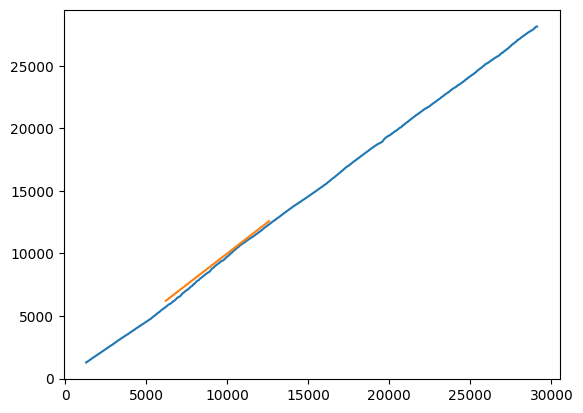

In [83]:
# plt.plot(np.load('/Users/kavidey/github/PianoConcertoAccompaniment/experiments/offlineDTW/cache/rach2_mov1_O1_PO1/o_po_align.npy')[0], np.load('/Users/kavidey/github/PianoConcertoAccompaniment/experiments/offlineDTW/cache/rach2_mov1_O1_PO1/o_po_align.npy')[1])
# plt.plot(o_po_path[0], o_po_path[1])

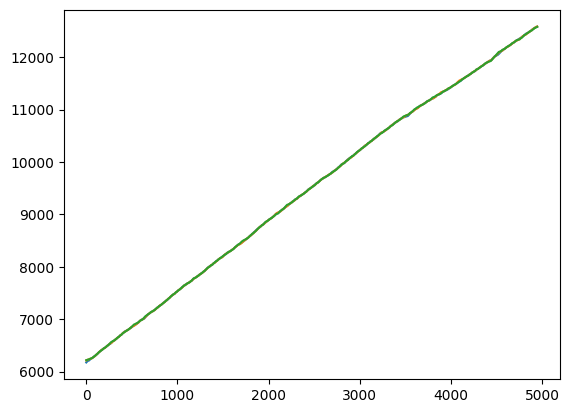

In [85]:
# plt.plot(np.load('/Users/kavidey/github/PianoConcertoAccompaniment/experiments/offlineDTW/s2/p_po_align.npy')[0], np.load('/Users/kavidey/github/PianoConcertoAccompaniment/experiments/offlineDTW/s2/p_po_align.npy')[1])
# plt.plot(p_po_path[0], p_po_path[1])
# plt.plot(wp_AB[0], wp_AB[1])

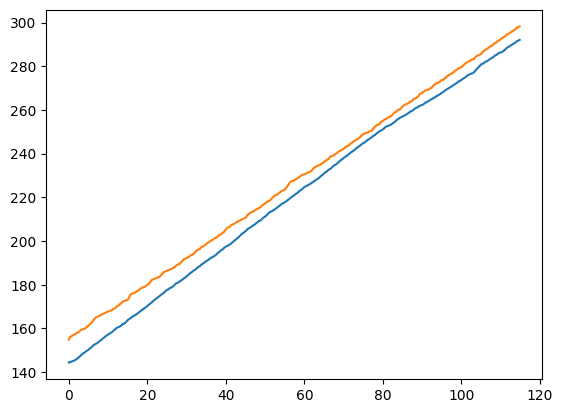

In [86]:
# plt.plot(wp_AC[0]*hop_sec, wp_AC[1]*hop_sec)
# plt.plot(np.load('/Users/kavidey/github/PianoConcertoAccompaniment/experiments/offlineDTW/s2/hyp.npy')[0], np.load('/Users/kavidey/github/PianoConcertoAccompaniment/experiments/offlineDTW/s2/hyp.npy')[1])

In [3]:
# dtw_wp = np.load('experiments/offlineDTW/cache/rach2_mov1_O1_PO1/o_po_align.npy')
# # dtw_wp = np.load('experiments/offlineDTW/s2/p_po_align.npy')

# wp_scaled = wp

# plt.plot(dtw_wp[0], dtw_wp[1], 'o', label="dtw")
# plt.plot(wp_scaled[0], wp_scaled[1], 'o', label="isa")
# plt.ylim(ymin=0)
# plt.xlim(xmin=0)
# plt.legend()

In [4]:
# p_file = f'{scenario_dir}/p.wav'
# y, sr = lb.core.load(p_file)

# hop_sec = hop_length / sr
# orch_start_sec, _ = system_utils.get_orchestra_query_boundaries(scenario_dir)
# orch_start_frm = orch_start_sec / hop_sec  # keep max precision, don't round

# # infer the start time of the query in the full mix recording (estimated)
# wp_BC = np.flipud(np.load(f'{cache_dir}/o_po_align.npy'))
# wp_BC = np.hstack((np.array([0,0]).reshape((2,-1)), wp_BC)) # prepend (0,0) to handle edge cases properly
# fullmix_start_frm = int(np.round(np.interp(orch_start_frm, wp_BC[1,:], wp_BC[0,:])))

# F_p = isa.calculate_cqt(y, sr, hop_length)  # piano features
# F_po = np.load(f'{cache_dir}/po_subtracted_cqt.npy') # full mix features
# F_po = F_po[:,fullmix_start_frm:] # truncate to start of query
# segments_p = split_into_five_second_segments(F_p)

# F_po_subtracted, wp_AB = isa.isa_chroma(F_p, F_po, segments_p)

In [5]:
# wp_AB = np.load('experiments/offlineDTW/s2/p_po_align.npy')

In [6]:
# # infer piano-orchestra alignment
# wp_AB_ = wp_AB.copy()
# wp_AB_[1,:] = wp_AB_[1,:] + fullmix_start_frm
# wp_AC = align_tools.infer_alignment(wp_AB_, wp_BC, frames=True)
# np.save(f'{out_dir}/hyp.npy', wp_AC*hop_sec)

In [7]:
# system_utils.get_orchestra_query_boundaries(scenario_dir)

In [8]:
# import matplotlib.pyplot as plt

# alignment1 = wp_AB_
# alignment2 = wp_BC
# alignment3 = wp_AC

# plt.plot(alignment1[1], alignment1[0], label='AB')
# plt.plot(alignment2[1], alignment2[0], label='BC')
# plt.plot(alignment3[1], alignment3[0], label='AC')
# plt.xlabel('Source Time')
# plt.ylabel('Aligned Time')
# plt.ylim(ymin=0)
# plt.xlim(xmin=0)
# plt.legend()
# plt.show()